# Hello Image Classification

This basic introduction to OpenVINO™ shows how to do inference with an image classification models such as renset-50 (Tensorflow) and resnet-18 (PyTorch).

Refer to [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) to download a wide range of pre-trained models and ready-to-run demos. For more information about how OpenVINO IR models are created, refer to the [TensorFlow to OpenVINO](../tensorflow-classification-to-openvino/tensorflow-classification-to-openvino.ipynb) tutorial.


#### Table of contents:

- [Imports](#Imports)
- [Load an Image](#Load-an-Image) 
- [Download the ImageNet-2012 Labels](#Download-the-ImageNet-2012-Labels)
- [Run Inference with PyTorch Model](#Run-Inference-with-PyTorch-Model)
- [Conversion of PyTorch Model into OpenVINO Intermediate Format](#Conversion-of-PyTorch-Model-into-OpenVINO-Intermediate-Format)
- [Benchmark Inference Performance](#Benchmark-Inference-Performance)
- [Select Inference Device](#Select-Inference-Device)
- [Run Inference with Optimized Model](#Run-Inference-with-Optimized-Model)
- [Performance Improvement with OpenVINO](#Performance-Improvement-with-OpenVINO)



In [1]:
import platform

# Install dependencies
%pip install -q "openvino==2025.1.0" tqdm

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

## Load an Image
[back to top ⬆️](#Table-of-contents:)


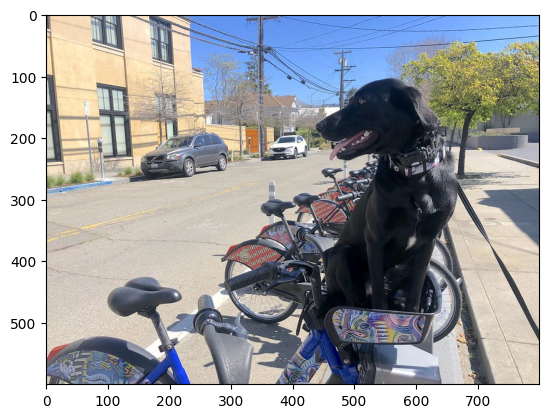

In [3]:
# Download the image from the openvino_notebooks storage
image_filename = Path("data/coco_bike.jpg")
if not image_filename.exists():
    download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg",
        directory="data",
    )
# The MobileNet model expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename=str(image_filename)), code=cv2.COLOR_BGR2RGB)

# Resize to MobileNet image shape
input_image = cv2.resize(src=image, dsize=(224, 224))
#input_image = input_image.transpose(2, 0, 1)

# Reshape to model input shape.
input_image = np.expand_dims(input_image, 0)
plt.imshow(image);

## Download the ImageNet-2012 Labels
[back to top ⬆️](#Table-of-contents:)


In [4]:
imagenet_filename = Path("data/imagenet_2012.txt")

if not imagenet_filename.exists():
    download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
        directory="data",
    )

imagenet_classes = imagenet_filename.read_text().splitlines()
# The model description states that for this model, class 0 is a background.
# Therefore, a background must be added at the beginning of imagenet_classes.
imagenet_classes = ["background"] + imagenet_classes

### Run Inference with PyTorch Model
[back to top ⬆️](#Table-of-contents:)

In [5]:
from PIL import Image
import numpy as np
import torch
from pathlib import Path
import torchvision
from torchvision.models import resnet18

# get default weights using available weights Enum for model
weights = torchvision.models.ResNet18_Weights.DEFAULT

# create model topology and load weights
model = resnet18(weights=weights)

# switch model to inference mode
model.eval()

# Prepare Input Data
image_filename = Path("data/coco_bike.jpg")
# The model expects images in RGB format.
image = Image.open(image_filename)

# Initialize the Weight Transforms
preprocess = weights.transforms()

# Apply it to the input image
img_transformed = preprocess(image)

# Add batch dimension to image tensor
input_tensor = img_transformed.unsqueeze(0)

imagenet_filename = Path("data/imagenet_2012.txt")

# Perform model inference on input tensor
pt_infer_result = model(input_tensor)
result_index = np.argmax(pt_infer_result.detach().numpy())
imagenet_classes = imagenet_filename.read_text().splitlines()
imagenet_classes[result_index]

'n02099267 flat-coated retriever'

## Conversion of PyTorch Model into OpenVINO Intermediate Format  
[back to top ⬆️](#Table-of-contents:)

In [6]:
import openvino as ov
import torch
from pathlib import Path
import torchvision
from torchvision.models import resnet18

# get default weights using available weights Enum for model
weights = torchvision.models.ResNet18_Weights.DEFAULT

# create model topology and load weights
model = resnet18(weights=weights)

# switch model to inference mode
model.eval()

# Convert model to openvino.runtime.Model object
ov_model = ov.convert_model(model, input=[[1, 3, 224, 224]])
prep = ov.preprocess.PrePostProcessor(ov_model)
prep.input("x").tensor().set_layout(ov.Layout("nchw"))
prep.input("x").preprocess().mean([123.675,116.28,103.53])
prep.input("x").preprocess().scale([58.395,57.12,57.375])
ov_model = prep.build()
base_artifacts_dir = Path("./artifacts/public/resnet-18-pytorch/ov_format/").expanduser()
ov_model_path = base_artifacts_dir / "resnet-18-pytorch.xml"
ov.save_model(ov_model,ov_model_path)

In [7]:
ov_model

<Model: 'Model2'
inputs[
<ConstOutput: names[x] shape[1,3,224,224] type: f32>
]
outputs[
<ConstOutput: names[x.45] shape[1,1000] type: f32>
]>

### Benchmark Inference Performance   
[back to top ⬆️](#Table-of-contents:)

In [16]:
!benchmark_app -m artifacts/public/resnet-18-pytorch/ov_format/resnet-18-pytorch.xml -d GPU

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] Device info:
[ INFO ] GPU
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(GPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 12.00 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [N,C,H,W] / [1,3,224,224]
[ INFO ] Model outputs:
[ INFO ]     x.45 (node: aten::linear/Add) : f32 / [...] / [1,1000]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configur

In [8]:
!benchmark_app -m artifacts/public/resnet-18-pytorch/ov_format/resnet-18-pytorch.xml -d NPU

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] Device info:
[ INFO ] NPU
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(NPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 14.00 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [N,C,H,W] / [1,3,224,224]
[ INFO ] Model outputs:
[ INFO ]     x.45 (node: aten::linear/Add) : f32 / [...] / [1,1000]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configur

## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [9]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='AUTO')

### Run Inference with Optimized Model   
[back to top ⬆️](#Table-of-contents:)

In [10]:
import openvino as ov
import cv2
import numpy as np
core = ov.Core()
base_artifacts_dir = Path("./artifacts/public/resnet-18-pytorch/ov_format/").expanduser()
ov_model_path = base_artifacts_dir / "resnet-18-pytorch.xml"
model_ov = core.read_model(model=ov_model_path)
compiled_model = core.compile_model(model=model_ov, device_name=device.value)
output_layer = compiled_model.output(0)

# Image Preprocessing 
image = cv2.cvtColor(cv2.imread(str(image_filename)), cv2.COLOR_BGR2RGB)
input_image = cv2.resize(src=image, dsize=(224, 224))
input_image = input_image.transpose(2, 0, 1)
input_tensor_ov = np.expand_dims(input_image, 0)

# Display the preprocessed input image
#cv2.imshow("Input",image)
#cv2.waitKey(0)

# Execute inference on the compiled model
result_infer = compiled_model([input_tensor_ov])[output_layer]
result_index = np.argmax(result_infer)

# Get the predicted class from the ImageNet 2012 label file
imagenet_filename = Path("data/imagenet_2012.txt")
imagenet_classes = imagenet_filename.read_text().splitlines()
print('Inference Result: ', imagenet_classes[result_index])

Inference Result:  n02099267 flat-coated retriever


### Performance Improvement with OpenVINO   
[back to top ⬆️](#Table-of-contents:)

In [11]:
%%timeit

# Run model inference
model(input_tensor)

65 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit

# Run model inference
compiled_model([input_tensor_ov])[output_layer]

2.64 ms ± 37 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
